In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from torch.autograd import Variable

import os
import time
import utils
import numpy as np

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import networks
import importlib

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
seed = 1234
torch.set_default_dtype(torch.float32)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [4]:
# layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1] # Network structure
net = networks.FeedforwardNeuralNetwork(2, 50,1,8) #  Network initialization
net.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-7): 7 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
n_epochs = 20000
lossFunction = nn.MSELoss()

from torchimize.functions import lsq_lma
# coeffs_list = lsq_lma(fnn.parameters(), function=lossFunction)
optimizer = optim.Adam(net.parameters(), lr=0.00003)

x_f_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(0.).float().to(device).requires_grad_(True)
optimizer_adam_weight = torch.optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=0.0003)

In [6]:
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Modelling


In [7]:
loss_hist = []
start_time = time.time()

for epoch in range(n_epochs):
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = net(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y2_hat = net(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # sample training data loss
    y3_hat = net(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    combined_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + x_f_s.detach() + x_label_s.detach() + torch.exp(-x_data_s.detach()) * data_loss + x_data_s.detach()
    combined_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + torch.exp(-x_label_s) * bc_loss.detach() + x_label_s + x_f_s + torch.exp(-x_data_s) * data_loss.detach() + x_data_s
    loss.backward()
    optimizer_adam_weight.step()
    
    # record the loss
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, total loss: {mse_loss.item():.5f}, minimum loss: {min(loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}')
    pass

end_time = time.time()

print('run time:', end_time - start_time)
print('Adam done!')

0/20000 PDE Loss: 0.00001, BC Loss: 677.80835, data loss: 426.80795, total loss: 1104.61633, minimum loss: 1104.61633
the weight is 1.00030, 0.99970. 0.99970
500/20000 PDE Loss: 0.00082, BC Loss: 39.42705, data loss: 21.51913, total loss: 60.94701, minimum loss: 60.94701
the weight is 1.16217, 0.88542. 0.88666
1000/20000 PDE Loss: 0.15778, BC Loss: 3.85791, data loss: 7.66756, total loss: 11.68325, minimum loss: 11.68325
the weight is 1.34082, 0.88357. 0.88178
1500/20000 PDE Loss: 0.08281, BC Loss: 0.19728, data loss: 0.41703, total loss: 0.69711, minimum loss: 0.69711
the weight is 1.50917, 0.88338. 0.88034
2000/20000 PDE Loss: 0.00704, BC Loss: 0.00119, data loss: 0.00200, total loss: 0.01023, minimum loss: 0.01023
the weight is 1.78149, 0.88405. 0.88137
2500/20000 PDE Loss: 0.00384, BC Loss: 0.00106, data loss: 0.00181, total loss: 0.00671, minimum loss: 0.00671
the weight is 2.09236, 0.88497. 0.88284
3000/20000 PDE Loss: 0.00224, BC Loss: 0.00105, data loss: 0.00175, total loss: 0.

Text(0.5, 1.0, 'IPINN')

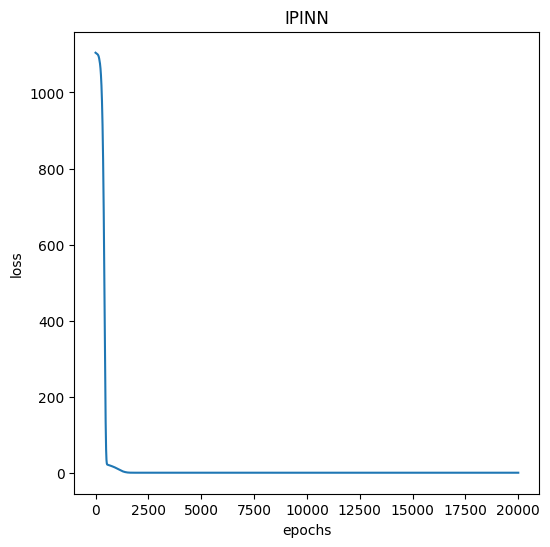

In [8]:
fig = plt.figure(figsize=(6,6))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')

In [9]:
# Evaluate the model on the test set
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0014
